# Intesa Sanpaolo: AI4Citizens

## Tutorial Reti Neurali

In questo tutorial impareremo a:
- usare la **differenziazione automatica**;
- costruire e allenare una [rete neurale artificiale](https://www.wikiwand.com/it/Rete_neurale_artificiale) usando Tensorflow; 
- migliorare le performance di una rete neurale usando alcuni accorgimenti di base;
- usare il **Transfer Learning** sfruttando i pesi di una rete allenata su un dataset di un altro dominio; 
- generare dati sintetici usando gli **autoencoder**;
- costruire una **GAN**.

Punti di attenzione:
- dato il poco tempo a disposizione, questo tutorial vuole essere una piccola introduzione per iniziare a usare Tensorflow velocemente. Per una trattazione esaustiva, si prega di consultare la [documentazione ufficiale](https://www.tensorflow.org/api_docs);
- gli esempi presentati in questo notebook sono molto semplicistici, utili per capire come usare Tensorflow ma sono molto lontani da un codice di produzione. 

---


### Installazione pacchetti mancanti e aggiornamento Tensorflow

Su Colab è possibile eseguire comandi di terminale anteponendo il punto escamativo "!" al comando che vogliamo dare. Nella cella qui sotto andiamo a installare il pacchetto [emnist](https://www.nist.gov/itl/products-and-services/emnist-dataset) usando pip. 

In [1]:
! python --version

Python 3.7.13


In [2]:
! pip install emnist

In [3]:
! pip freeze

absl-py==1.1.0
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
astunparse==1.6.3
attrs==21.4.0
backcall==0.2.0
beautifulsoup4==4.11.1
bleach==5.0.0
cachetools==5.2.0
certifi==2022.5.18.1
cffi==1.15.0
charset-normalizer==2.0.12
cycler==0.11.0
debugpy==1.6.0
decorator==5.1.1
defusedxml==0.7.1
emnist==0.0
entrypoints==0.4
fastjsonschema==2.15.3
flatbuffers==2.0
fonttools==4.33.3
gast==0.5.3
google-auth==2.7.0
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
grpcio==1.46.3
h5py==3.7.0
idna==3.3
importlib-metadata==4.11.4
importlib-resources==5.7.1
ipykernel==6.13.1
ipython==7.34.0
ipython-genutils==0.2.0
ipywidgets==7.7.0
jedi==0.18.1
Jinja2==3.1.2
jsonschema==4.6.0
jupyter==1.0.0
jupyter-client==7.3.4
jupyter-console==6.4.3
jupyter-core==4.10.0
jupyterlab-pygments==0.2.2
jupyterlab-widgets==1.1.0
keras==2.8.0
Keras-Preprocessing==1.1.2
kiwisolver==1.4.2
libclang==14.0.1
Markdown==3.3.7
MarkupSafe==2.1.1
matplotlib==3.5.2
matplotlib-inline==0.1.3
mistune==0.8.4
nbclient==0.6.4
nbconvert==6

### Caricamento pacchetti

Importiamo alcune funzioni/oggetti che useremo dopo. 

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from emnist import extract_training_samples, extract_test_samples
from matplotlib.pyplot import matshow, subplots, hist, show
from numpy import unique, prod, arange, exp, minimum, argmax, mean, vstack, hstack
from numpy.random import randint, choice, normal
from string import ascii_lowercase
from tqdm import tqdm
from tensorflow import GradientTape, constant as tf_constant, Variable, \
ones_like, zeros_like, function as tf_function, __version__ as tf_version, \
print as tf_print
from tensorflow.data import Dataset
from tensorflow.random import normal as tf_normal
from tensorflow.math import reduce_mean as tf_reduce_mean, sqrt as tf_sqrt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, \
MaxPool2D, Reshape, BatchNormalization, Activation, LeakyReLU, Conv2DTranspose,\
LeakyReLU, Concatenate, RandomTranslation, RandomRotation, Add
from tensorflow.keras.losses import SparseCategoricalCrossentropy, \
MeanSquaredError, BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy

In [5]:
print("tensorflow ", tf_version)

tensorflow  2.8.2


---



### Differenziazione automatica

Data una funzione *bella* $y = f(x)$ e un punto del suo dominio $x_0$, voglio sapere in quale direzione mi devo muovere per raggiungere un punto di minimo. Per esempio, $y = x^2$ e $x_0=3$. La derivata è $y'(x) = 2x$ e $y'(3) = 6$. Per raggiungere il minimo (che si trova in $x=0$), dobbiamo andare nella direzione opposta. L'operazione di differenziazione automatica è già implementata in Tensorflow. 

In [6]:
x = tf_constant(3.0)
with GradientTape() as tape:
    tape.watch(x)
    y = x * x
    dy_dx = tape.gradient(y, x) 
    print(dy_dx.numpy())

6.0


A questo punto la domanda spontanea è: e quindi? Supponiamo di voler fare una regressione lineare. 




In [7]:
set_random_seed(1102)

x1 = tf_normal([1000]) # <-- feature 1
x2 = tf_normal([1000]) # <-- feature 2
x3 = tf_normal([1000]) # <-- feature 3

# variabile target
y = 3.0 * x1 - 5.0 * x2 - 1.0 * x3 # <-- coefficienti = (3.0, -5.0, -1.0)

Supponiamo di non conoscere i ciefficienti a priori e di volerli ricavare dai dati. 

In [8]:
c = Variable([0.0, 0.0, 0.0]) # <-- inizializzazione
for j in range(100):
    with GradientTape() as tape:
        tape.watch(c)
        y_pred = c[0] * x1 + c[1] * x2 + c[2] * x3 # <-- predizione
        loss = tf_reduce_mean((y - y_pred)**2) # <-- quanto sto sbagliando?
        grad =  tape.gradient(loss, c) # <-- differenziazione automatica
        grad_normalized = grad / tf_sqrt(max(sum(grad**2), 0.00001)) 
        c = c - 10./(100.+j) * grad_normalized # <-- aggiorno i pesi
        if (j+1) % 10 == 0:
            print("iteration =", j+1, 
                  "\t loss =", loss.numpy(), 
                  "\t coeff =", c.numpy())
print("Coefficients found", c.numpy())

iteration = 10 	 loss = 25.12955 	 coeff = [ 0.52038056 -0.79168564 -0.13981079]
iteration = 20 	 loss = 17.115704 	 coeff = [ 0.98871434 -1.517599   -0.27183333]
iteration = 30 	 loss = 11.107027 	 coeff = [ 1.4126943 -2.1885927 -0.3976887]
iteration = 40 	 loss = 6.7033973 	 coeff = [ 1.7979974 -2.813216  -0.5188001]
iteration = 50 	 loss = 3.601707 	 coeff = [ 2.1486433  -3.3984272  -0.63654983]
iteration = 60 	 loss = 1.567939 	 coeff = [ 2.466982   -3.9501686  -0.75251335]
iteration = 70 	 loss = 0.41832167 	 coeff = [ 2.7527654  -4.474079   -0.86905974]
iteration = 80 	 loss = 0.0060263406 	 coeff = [ 2.9942436 -4.978541  -0.9934099]
iteration = 90 	 loss = 0.0010095595 	 coeff = [ 2.981169  -4.989828  -1.0048003]
iteration = 100 	 loss = 0.0009473449 	 coeff = [ 2.9836383 -4.9955544 -1.0117772]
Coefficients found [ 2.9836383 -4.9955544 -1.0117772]


---



### Caricamento dataset delle lettere

Carichiamo il dataset delle lettere scritte a mano usando la funzione `extract_training_samples` e `extract_test_samples`. I dati così caricati sono già divisi in train set (usato per allenare i pesi della rete) e test set (dati non presenti durante il training e usati solo per testare le performance). 

Come primo passo, normalizziamo tutte le features nel range [0, 1] e facciamo in modo che le etichette abbiano una numerazione che inizi da 0. 

In [9]:
letters_train_features, letters_train_labels \
= extract_training_samples('letters')
letters_train_features = letters_train_features / 255.0
letters_train_labels = letters_train_labels - 1
letters_train_labels_one_hot = to_categorical(letters_train_labels, len(unique(letters_train_labels)))

print("Dimensioni della feature table =", letters_train_features.shape)
print("Dimensione del vettore target  =", letters_train_labels.shape)

Dimensioni della feature table = (124800, 28, 28)
Dimensione del vettore target  = (124800,)


In [10]:
letters_test_features, letters_test_labels \
= extract_test_samples('letters')
letters_test_features = letters_test_features / 255.0
letters_test_labels = letters_test_labels - 1
letters_test_labels_one_hot = to_categorical(letters_test_labels, len(unique(letters_test_labels)))

print("Dimensioni della feature table =", letters_test_features.shape)
print("Dimensione del vettore target  =", letters_test_labels.shape)

Dimensioni della feature table = (20800, 28, 28)
Dimensione del vettore target  = (20800,)


---



### Visualizzazione dei dati

Possiamo disegna qualche istanza del training set.

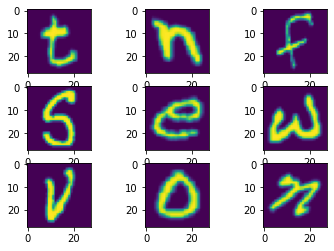

In [11]:
def plot_samples(data) -> None:
    f, axarr = subplots(3,3)
    rnd_ints = randint(low=0, high=data.shape[0], size=prod(axarr.shape))
    for j, ax in enumerate([item for sublist in axarr for item in sublist]):
        ax.imshow(data[rnd_ints[j]])

plot_samples(letters_train_features)

### Distribuzione della variabile target

Controlliamo che la variabile target sia equidistribuita nelle varie classi. 

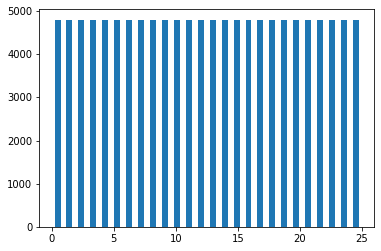

In [12]:
hist(letters_train_labels, rwidth=0.5, bins=len(unique(letters_train_labels)))
show()

---

### Prima rete neurale aritificiale

In modo molto semplicistico, possiamo affermare che i tre ingredienti per una rete neurale artificiale sono:
- architettura della rete; 
- la loss da minimizzare;
- l'ottimizzatore che aggiorna i pesi (backpropagation) della rete affinché la loss venga minimizzata. 

![Un esempio di neural network](https://raw.githubusercontent.com/ngshya/isp-tutorial/main/neutral-network.svg)

Partiamo dunque con l'architettura della rete concatenando in sequenza diversi layer già implementati in Tensorflow. 

In [13]:
set_random_seed(1102)

def get_model_dummy(input_shape, output_shape, units=64) -> Model:
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(units, activation='relu'),
        Dense(output_shape, activation="softmax")
    ])
    return model

model_dummy = get_model_dummy(
    letters_train_features.shape[1:], 
    len(unique(letters_train_labels)), 
    units=64
)

Possiamo anche disegnare la nostra rete usando il comando `plot_model`.

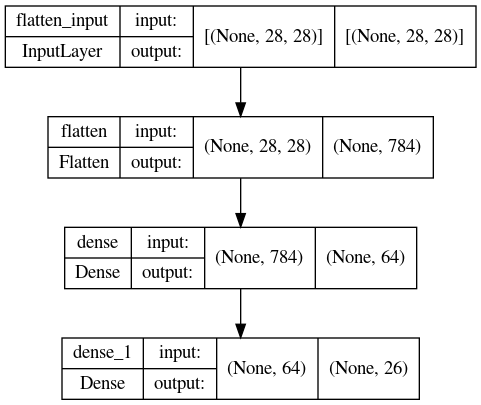

In [14]:
plot_model(model_dummy, show_shapes=True)

In [15]:
for layer in model_dummy.layers:
    print("\n", layer.name)
    for w in layer.weights:
        print(w.numpy())


 flatten

 dense
[[-0.02528919 -0.07248795 -0.02894546 ... -0.06439833  0.07174877
   0.033105  ]
 [ 0.00592589  0.00246331 -0.03357683 ...  0.00850936 -0.07185006
  -0.0731879 ]
 [-0.0597082  -0.00249805 -0.07100466 ...  0.07994451  0.06104048
   0.0607662 ]
 ...
 [ 0.0315987  -0.03672904 -0.03997326 ...  0.08310195 -0.04421817
  -0.06897417]
 [ 0.04569403 -0.00505038 -0.07373524 ... -0.03028427  0.0826324
   0.00192937]
 [ 0.03537109 -0.01036     0.06420628 ...  0.07415505  0.07741291
  -0.07533807]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 dense_1
[[-0.05277354 -0.06114247  0.04630554 ...  0.06777027  0.18752727
  -0.13171239]
 [ 0.03465942  0.08238325 -0.18416785 ...  0.22612175  0.2126261
  -0.21976501]
 [-0.04663526 -0.09720434 -0.15946577 ... -0.01419055  0.06043342
   0.25777176]
 ...
 [ 0.23773634  0.17662928  0.12380922 

Compiliamo la nostra prima rete specificando l'[ottimizzatore](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), la [loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses) e la [metrica di monitoraggio](https://www.tensorflow.org/api_docs/python/tf/keras/metrics). Quest'ultima non è strettamente necessaria ai fini del training ma può essere utile monitorarla. 


In [16]:
model_dummy.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model_dummy.fit(
    letters_train_features, letters_train_labels, 
    batch_size=256, epochs=100, validation_split=0.2, verbose=2, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/100
390/390 - 4s - loss: 1.3246 - accuracy: 0.6299 - val_loss: 0.9688 - val_accuracy: 0.7262 - 4s/epoch - 9ms/step
Epoch 2/100
390/390 - 3s - loss: 0.8575 - accuracy: 0.7544 - val_loss: 0.7853 - val_accuracy: 0.7762 - 3s/epoch - 6ms/step
Epoch 3/100
390/390 - 2s - loss: 0.7145 - accuracy: 0.7956 - val_loss: 0.6872 - val_accuracy: 0.8030 - 2s/epoch - 6ms/step
Epoch 4/100
390/390 - 3s - loss: 0.6271 - accuracy: 0.8192 - val_loss: 0.6291 - val_accuracy: 0.8190 - 3s/epoch - 6ms/step
Epoch 5/100
390/390 - 2s - loss: 0.5681 - accuracy: 0.8345 - val_loss: 0.5771 - val_accuracy: 0.8310 - 2s/epoch - 6ms/step
Epoch 6/100
390/390 - 3s - loss: 0.5234 - accuracy: 0.8450 - val_loss: 0.5432 - val_accuracy: 0.8401 - 3s/epoch - 6ms/step
Epoch 7/100
390/390 - 2s - loss: 0.4903 - accuracy: 0.8549 - val_loss: 0.5193 - val_accuracy: 0.8487 - 2s/epoch - 6ms/step
Epoch 8/100
390/390 - 3s - loss: 0.4627 - accuracy: 0.8618 - val_loss: 0.5031 - val_accuracy: 0.8533 - 3s/epoch - 7ms/step
Epoch 9/100
390/

### Proviamo con la convoluzione

I [layer convoluzionali](https://www.wikiwand.com/it/Rete_neurale_convoluzionale) sono progettati appositamente per i task di computer vision. 

![Convoluzione](https://github.com/ngshya/isp-tutorial/raw/main/convolution.png)

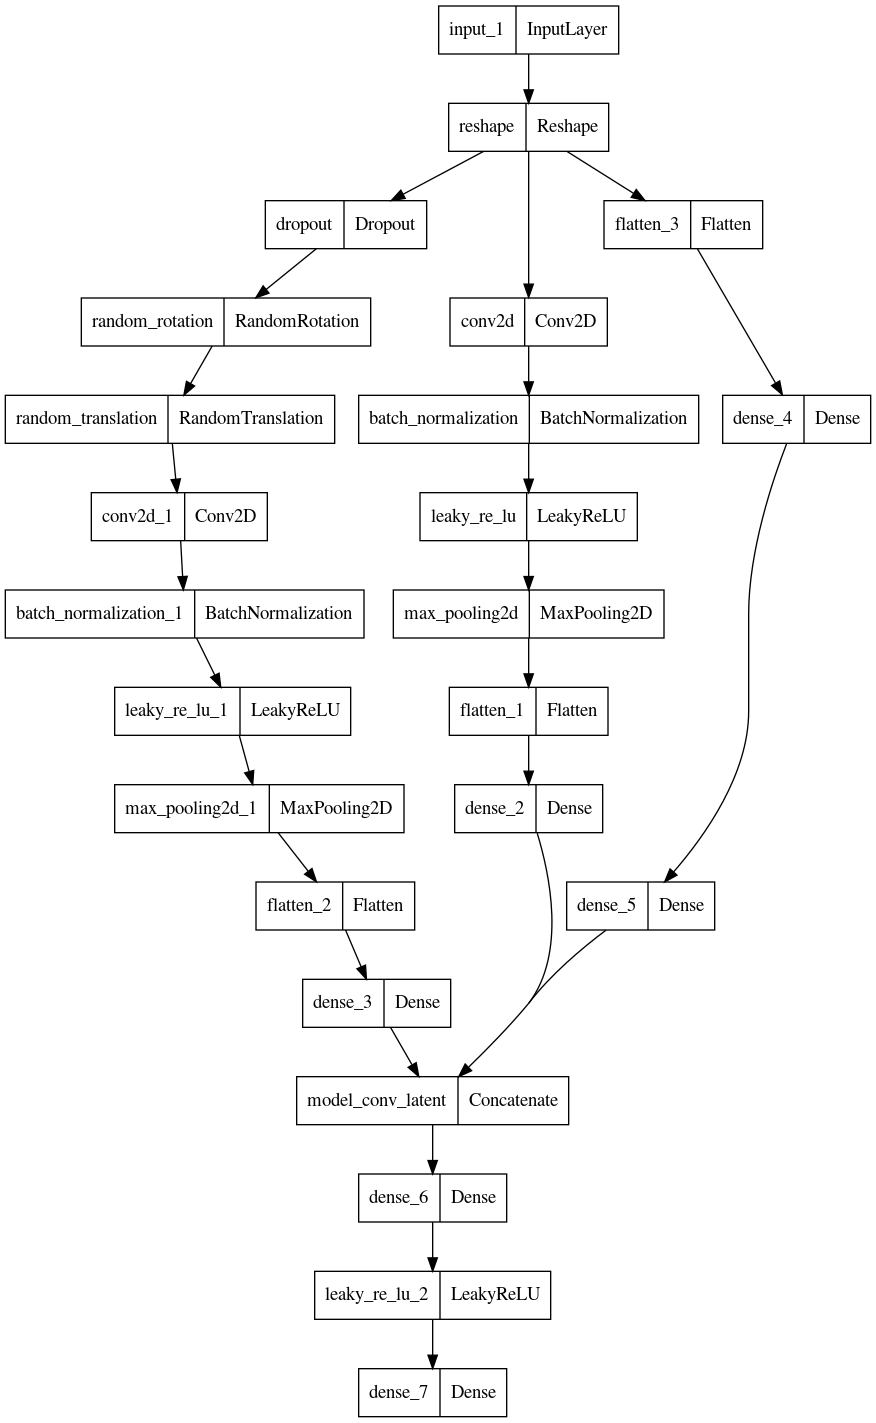

In [17]:
set_random_seed(1102)

def get_model_conv(input_shape, output_shape) -> Model:
    layer_input = Input(shape=input_shape)
    reshaped = Reshape((28, 28, 1))(layer_input)

    conv1 = Conv2D(32, (3,3))(reshaped)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)
    conv1 = MaxPool2D()(conv1)
    conv1 = Flatten()(conv1)
    conv1 = Dense(32, activation='sigmoid')(conv1)

    drop2 = Dropout(0.05)(reshaped)
    rot2 = RandomRotation(factor=(-0.05, +0.05))(drop2)
    tran2 = RandomTranslation(
        height_factor=(-0.05, +0.05), 
        width_factor=(-0.05, +0.05)
    )(rot2)
    conv2 = Conv2D(32, (5,5))(tran2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU()(conv2)
    conv2 = MaxPool2D()(conv2)
    conv2 = Flatten()(conv2)
    conv2 = Dense(32, activation='sigmoid')(conv2)

    fc1 = Flatten()(reshaped)
    fc1 = Dense(64, activation='sigmoid')(fc1)
    fc1 = Dense(32, activation='sigmoid')(fc1)

    layer_latent = Concatenate(name="model_conv_latent")((conv1, conv2, fc1))
    x = Dense(64, activation='linear')(layer_latent)
    x = LeakyReLU()(x)
    layer_output = Dense(output_shape, activation="softmax")(x)
    model = Model(layer_input, layer_output)
    return model

model_conv = get_model_conv(
    letters_train_features.shape[1:], 
    len(unique(letters_train_labels))
)

plot_model(model_conv)

In [18]:
# model_conv.compile(
#     optimizer='adam',
#     loss=SparseCategoricalCrossentropy(),
# )

# model_conv.save("model_conv_random.h5")
model_conv = load_model("model_conv_trained.h5")

# model_conv.fit(
#     letters_train_features, letters_train_labels, 
#     batch_size=256, epochs=100, validation_split=0.2, verbose=2, 
#     callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
# )

# model_conv.save("model_conv_trained.h5")

### Performance sul test set

Fin'ora abbiamo usato il training set e la validation set. Vediamo come le performance delle due reti sopra allenate sul test set. 

In [19]:
preds_dummy = model_dummy.predict(letters_test_features)
print("Dummy model accuracy =", mean(argmax(preds_dummy, axis=1) == argmax(letters_test_labels_one_hot, axis=1)))

Dummy model accuracy = 0.8695192307692308


In [20]:
preds_conv = model_conv.predict(letters_test_features)
print("Conv model accuracy =", mean(argmax(preds_conv, axis=1) == argmax(letters_test_labels_one_hot, axis=1)))

Conv model accuracy = 0.9046153846153846


In [21]:
del model_dummy

---



### Problema: training set molto piccolo

Cambiamo il dataset. Questa volta prendiamo le immagini che riportano le cifre. Per complicarci le cose, selezioniamo casualmente solo 60 istanze dal training set. 

In [22]:
set_random_seed(1102)

digits_train_features, digits_train_labels \
= extract_training_samples('digits')
digits_train_features = digits_train_features / 255.0
idx = choice(arange(0, digits_train_features.shape[0]), size=60, replace=False)
digits_train_features = digits_train_features[idx, :, :]
digits_train_labels = digits_train_labels[idx]
digits_train_labels_one_hot = to_categorical(digits_train_labels, len(unique(digits_train_labels)))

print("Dimensioni della feature table =", digits_train_features.shape)
print("Dimensione del vettore target  =", digits_train_labels.shape)

Dimensioni della feature table = (60, 28, 28)
Dimensione del vettore target  = (60,)


In [23]:
digits_test_features, digits_test_labels \
= extract_test_samples('digits')
digits_test_features = digits_test_features / 255.0
digits_test_labels_one_hot = to_categorical(digits_test_labels, len(unique(digits_test_labels)))

print("Dimensioni della feature table =", digits_test_features.shape)
print("Dimensione del vettore target  =", digits_test_labels.shape)

Dimensioni della feature table = (40000, 28, 28)
Dimensione del vettore target  = (40000,)


Come prima, ispezioniamo il dataset disegnando qualche istanza a video. 

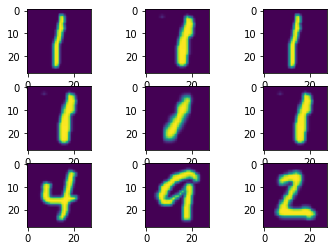

In [24]:
plot_samples(digits_train_features)

E studiamo un attimo anche la distribuzione delle varie classi. Ci sono delle classi che hanno solo 3 istanze! 

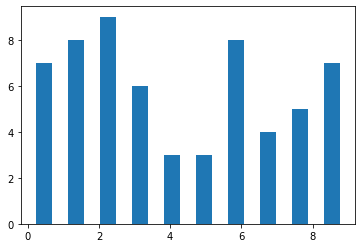

In [25]:
hist(digits_train_labels, rwidth=0.5, bins=len(unique(digits_train_labels)))
show()

Proviamo subito con una rete molto semplice per vedere fino a dove riusciamo ad arrivare. 

In [26]:
set_random_seed(1102)

model_dummy_4_digits = get_model_dummy(
    digits_train_features.shape[1:], 
    len(unique(digits_train_labels)), 
    16
)

model_dummy_4_digits.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [27]:
model_dummy_4_digits.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 16)                12560     
                                                                 
 dense_9 (Dense)             (None, 10)                170       
                                                                 
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


Questa rete ha 12730 pesi allenabili. 

In [28]:
model_dummy_4_digits.fit(
    digits_train_features, digits_train_labels, 
    batch_size=256, epochs=100, validation_split=0.2, verbose=0, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

In [29]:
model_dummy_4_digits.evaluate(digits_test_features, digits_test_labels)

1250/1250 [==============================] - 6s 5ms/step - loss: 1.4132 - accuracy: 0.5739


[1.4132490158081055, 0.5739250183105469]

Non così male, considerando che abbiamo solo 60 istanze nel training set! Che cosa possiamo fare per migliorare? 3 Idee: 

- ottimizzare l'architettura della rete (esercizio a casa); 
- sfruttare il transfer learning; 
- generare dati sintetici. 

--- 



### Transfer Learning

Una delle magie delle reti neurali è che possiamo prendere una rete allenata su un dominio diverso dal nostro e usarlo per migliorare il nostro task. In questo esempio specifico, prendiamo la **rete allenata sulle lettere dell'alfabeto**, togliamo gli ultimi layer, fissiamo i pesi e poi aggiungiamo un paio di layer fully-connected per imparare a **classificare le cifre**.  

In [30]:
model_conv_input = model_conv.layers[0]
model_conv_latent = model_conv.layers[20]

print(model_conv_input.name)
print(model_conv_latent.name)

input_1
model_conv_latent


In [31]:
set_random_seed(1102)

layer_output_digits = Dense(len(unique(digits_train_labels)), activation="softmax")(
    Dense(64, activation="relu")(model_conv_latent.output)
)
model_transfer = Model(model_conv_input.input, layer_output_digits)
model_conv.trainable = False

In [32]:
model_transfer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 reshape (Reshape)              (None, 28, 28, 1)    0           ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 28, 28, 1)    0           ['reshape[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 28, 28, 1)   0           ['dropout[0][0]']                
 n)                                                                                         

Da notare che i pesi allenabili sono solo 6858, che sono di meno rispetto a quelli della rete dummy che abbiamo usato sopra. 

In [33]:
set_random_seed(1102)

model_transfer.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model_transfer.fit(
    digits_train_features, digits_train_labels, 
    batch_size=256, epochs=100, validation_split=0.2, verbose=0, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

In [34]:
model_dummy_4_digits.evaluate(digits_test_features, digits_test_labels)

1250/1250 [==============================] - 7s 5ms/step - loss: 1.4132 - accuracy: 0.5739


[1.4132490158081055, 0.5739250183105469]

In [35]:
model_transfer.evaluate(digits_test_features, digits_test_labels)

1250/1250 [==============================] - 10s 8ms/step - loss: 0.5538 - accuracy: 0.8818


[0.5537604093551636, 0.8818249702453613]

Siamo riusciti a migliorare! :)

Può essere che sia dovuto al fatto di avere più neuroni, anche se non allenati su nulla? 

In [36]:
model_conv_random = load_model("model_conv_random.h5")

model_conv_random_input = model_conv_random.layers[0]
model_conv_random_latent = model_conv_random.layers[20]

set_random_seed(1102)

layer_output_digits_random = Dense(len(unique(digits_train_labels)), activation="softmax")(
    Dense(64, activation="relu")(model_conv_random_latent.output)
)
model_transfer_random = Model(model_conv_random_input.input, layer_output_digits_random)
model_conv.trainable = False

model_transfer_random.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model_transfer_random.fit(
    digits_train_features, digits_train_labels, 
    batch_size=256, epochs=100, validation_split=0.2, verbose=0, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

model_transfer_random.evaluate(digits_test_features, digits_test_labels)

1250/1250 [==============================] - 11s 9ms/step - loss: 1.1522 - accuracy: 0.6604


[1.152169108390808, 0.6603749990463257]

In [37]:
del model_dummy_4_digits
del model_transfer
del model_transfer_random

--- 



### Generazione dati sintetici

Un'altra delle possibili applicazioni delle reti neurali è la generazione dei dati sintetici. In questo esempio, sfruttiamo un [autoencoder](https://www.wikiwand.com/en/Autoencoder). 

![Un autoencoder](https://github.com/ngshya/isp-tutorial/raw/main/ae.png)

In [38]:
set_random_seed(1102)
model_conv.trainable = False

def get_model_ae(model_conv_input, model_conv_latent) -> Model:

    bottleneck = Dense(32, activation='linear')(model_conv_latent)
    model_encoder = Model(model_conv_input, bottleneck)

    layer_input_dec = Input(shape=32)
    x = Dense(64, activation='relu')(layer_input_dec)
    layer_output_ae = Dense(784, activation="sigmoid")(x)

    model_decoder = Model(layer_input_dec, layer_output_ae)

    model_ae = Sequential([
        model_encoder,
        model_decoder,
    ])

    return model_ae, model_encoder, model_decoder

model_ae, model_encoder, model_decoder = get_model_ae(
    model_conv_input.input, model_conv_latent.output
)

model_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 32)                377408    
                                                                 
 model_4 (Functional)        (None, 784)               53072     
                                                                 
Total params: 430,480
Trainable params: 56,176
Non-trainable params: 374,304
_________________________________________________________________


Facciamo un training alternato lettere/numeri. 

In [39]:
'''
set_random_seed(1102)

model_ae.compile(
    optimizer=Adam(learning_rate=0.005, amsgrad=True),
    loss=MeanSquaredError(),
    metrics=['mse']
)

for epoch in range(20):
    model_ae.fit(
        letters_train_features, 
        letters_train_features.reshape(letters_train_features.shape[0], 784), 
        batch_size=1024, epochs=1, verbose=0
    )
    model_ae.fit(
        digits_train_features, 
        digits_train_features.reshape(digits_train_features.shape[0], 784), 
        batch_size=32, epochs=1, validation_split=0.2, verbose=2
    )

model_ae.trainable = False
    
model_encoder.save("model_encoder.h5")
model_decoder.save("model_decoder.h5")
model_ae.save("model_ae.h5")
'''

'\nset_random_seed(1102)\n\nmodel_ae.compile(\n    optimizer=Adam(learning_rate=0.005, amsgrad=True),\n    loss=MeanSquaredError(),\n    metrics=[\'mse\']\n)\n\nfor epoch in range(20):\n    model_ae.fit(\n        letters_train_features, \n        letters_train_features.reshape(letters_train_features.shape[0], 784), \n        batch_size=1024, epochs=1, verbose=0\n    )\n    model_ae.fit(\n        digits_train_features, \n        digits_train_features.reshape(digits_train_features.shape[0], 784), \n        batch_size=32, epochs=1, validation_split=0.2, verbose=2\n    )\n\nmodel_ae.trainable = False\n    \nmodel_encoder.save("model_encoder.h5")\nmodel_decoder.save("model_decoder.h5")\nmodel_ae.save("model_ae.h5")\n'

Proviamo ora a generare qualche istanza aggiungendo del rumore alla rappresentazione latente. 

In [40]:
model_encoder = load_model("model_encoder.h5")
model_decoder = load_model("model_decoder.h5")

In [41]:
def show_synthetic_data(data) -> None:
    synthetic_data = model_decoder.predict(
        model_encoder.predict(
            data
        ) + normal(size=32, loc=0.0, scale=0.01) # <-- rumore!
    ).reshape((data.shape[0], 28, 28))
    synthetic_data_processed = minimum(exp(synthetic_data)-1, 1)

    f, axarr = subplots(2, data.shape[0])
    for j in range(data.shape[0]):
        axarr[0][j].imshow(data[j])
        axarr[1][j].imshow(synthetic_data_processed[j])

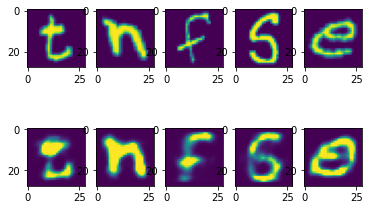

In [42]:
rnd_ints = randint(low=0, high=letters_train_features.shape[0], size=5)
show_synthetic_data(letters_train_features[rnd_ints])

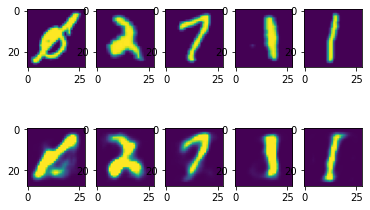

In [43]:
rnd_ints = randint(low=0, high=digits_train_features.shape[0], size=5)
show_synthetic_data(digits_train_features[rnd_ints])

Come possiamo sfruttare i dati sintetici per migliorare le performance di training? (Esercizio) 

I dati sintetici generati non ti sembrano così realistici? Hai ragione, in realtà la questione è più complicata di così. Per approfondimenti, vedi [Variational Autoencoder](https://www.wikiwand.com/en/Variational_autoencoder). 

---


### Generative Adversarial Networks

Sono reti neurali formati da due sotto-reti che *combattono* fra di loro. In particolare, una rete genera dati sintetici mentre l'altra cerca di distinguere i dati sintetici da quelli reali. 

In [44]:
def get_model_generator():

    layer_input = Input(shape=(100,))
    x = Dense(7*7*256, use_bias=False)(layer_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Reshape((7, 7, 256))(x)

    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)

    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    
    layer_output = Reshape((28, 28))(x)

    model = Model(layer_input, x)

    return model

In [45]:
def get_model_discriminator():

    layer_input = Input((28, 28))

    x = Reshape((28, 28, 1))(layer_input)

    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    layer_output = Dense(1)(x)

    model = Model(layer_input, layer_output)

    return model

In [46]:
set_random_seed(1102)

model_generator = get_model_generator()
model_discriminator = get_model_discriminator()

def discriminator_loss(real_output, fake_output):
    real_loss = BinaryCrossentropy(from_logits=True)(ones_like(real_output), real_output)
    fake_loss = BinaryCrossentropy(from_logits=True)(zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return BinaryCrossentropy(from_logits=True)(ones_like(fake_output), fake_output)

optimizer_generator = Adam(1e-4)
optimizer_discriminator = Adam(1e-4)

In [47]:
@tf_function
def train_step(images):

    noise = tf_normal([images.shape[0], 100])

    with GradientTape() as tape_generator, GradientTape() as tape_discriminator:

        generated_images = model_generator(noise, training=True)

        real_output = model_discriminator(images, training=True)
        fake_output = model_discriminator(generated_images, training=True)

        loss_generator = generator_loss(fake_output)
        loss_discriminator = discriminator_loss(real_output, fake_output)
        
        # tf_print("Generator Loss =", loss_generator, "\t Discriminator Loss =", loss_discriminator)

    grad_generator = tape_generator.gradient(loss_generator, model_generator.trainable_variables)
    grad_discriminator = tape_discriminator.gradient(loss_discriminator, model_discriminator.trainable_variables)

    optimizer_generator.apply_gradients(zip(grad_generator, model_generator.trainable_variables))
    optimizer_discriminator.apply_gradients(zip(grad_discriminator, model_discriminator.trainable_variables))

In [48]:
'''
set_random_seed(1102)

random_seeds = tf_normal([5, 100])

for epoch in tqdm(range(100)):
    for image_batch in Dataset.from_tensor_slices(letters_train_features).batch(512):
        train_step(image_batch)
    if (epoch+1)%5 == 0:
        synthetic_imgs = model_generator.predict(tf_normal([5, 100]))
        f, axarr = subplots(1, synthetic_imgs.shape[0])
        f.set_dpi(300)
        for j in range(synthetic_imgs.shape[0]):
            axarr[j].imshow(synthetic_imgs[j].reshape((28, 28)))

model_generator.save("model_generator.h5")
'''

model_generator = load_model("model_generator.h5")

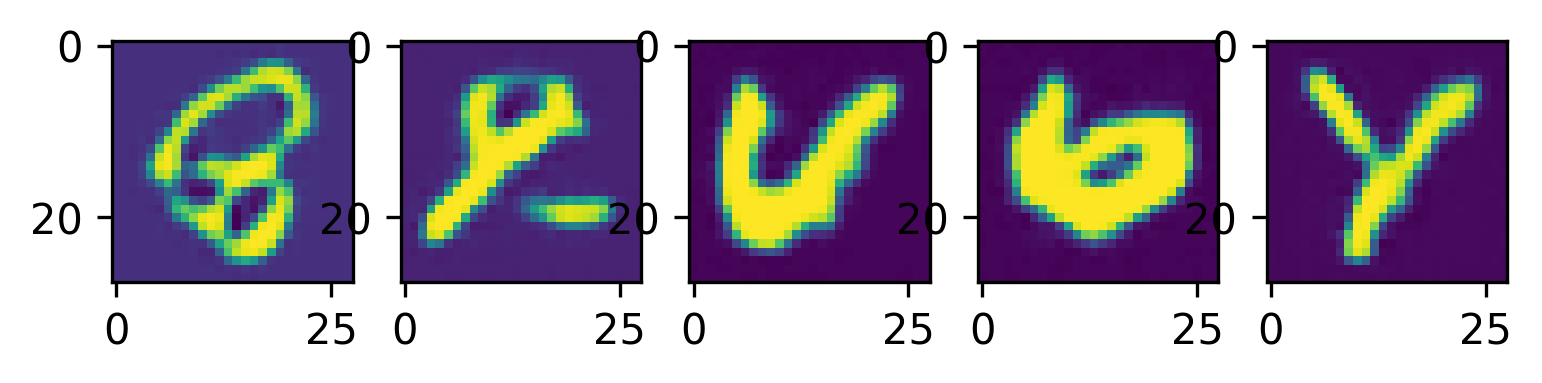

In [49]:
random_seeds = tf_normal([5, 100])
synthetic_imgs = model_generator.predict(tf_normal([5, 100]))
f, axarr = subplots(1, synthetic_imgs.shape[0])
f.set_dpi(300)
for j in range(synthetic_imgs.shape[0]):
    axarr[j].imshow(synthetic_imgs[j].reshape((28, 28)))